# Identify Customer Segments

In this project, we apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that was used was provided by Bertelsmann Arvato Analytics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time
import warnings

# magic word for producing visualizations in notebook
%matplotlib inline
# other settings
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

### Step 0: Data Loading

There are four files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. This information can be used to cluster the general population into groups with similar demographic properties. In the next step one can analyze how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Store a copy of the original dataset
azdias_raw = azdias.copy()
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Number of rows:', azdias.shape[0])
print('Number of columns:', azdias.shape[1])
#print(azdias.columns)
print(azdias.head())

Number of rows: 891221
Number of columns: 85
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...        

In [4]:
#print(azdias.dtypes)

In [5]:
#print(azdias.describe())

In [6]:
#Exploring the feature summary data
print('Number of rows:', feat_info.shape[0])
print('Number of columns:', feat_info.shape[1])
print(feat_info.head())

Number of rows: 85
Number of columns: 4
              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We use this file to help us make cleaning decisions during this stage of the project. First of all, we assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. Therefore, we need to do a little bit of parsing to make use of it to identify and clean the data. We  convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We also analyze how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing.

In [7]:
#First I want to investigate how much data is naturally missing in each column/row
missing_nat_col = azdias.isnull().sum(axis=0)
missing_nat_row = azdias.isnull().sum(axis=1)

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
count_unknown = []
for i in range(azdias.shape[1]):
    att_code = feat_info['missing_or_unknown'][i]
    #Empty data cells (naturally missing) are coded as NaN already through read_csv. 
    #For attributes with an empty list of missing or unknown codes I do not need to do anything
    if att_code == '[]':
        count_unknown.append(0)
    else:
        att_code = att_code.replace('[','').replace(']','').split(',')
        #For each attribute I create a list of transformed codes (strings -> integers if applicable), 
        #and count the coded values
        att_code_tr = []
        count_unknown_col = 0
        for elt in att_code:
            try:
                count_unknown_col += azdias.iloc[:,i].tolist().count(int(elt))
                att_code_tr.append(int(elt))
            except:
                count_unknown_col += azdias.iloc[:,i].tolist().count(elt)
                att_code_tr.append(elt)      
        count_unknown.append(count_unknown_col)
        azdias.iloc[:,i].replace(att_code_tr, np.NaN, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

In [9]:
# I provide in the table below the total number of missing values in each column, 
# with a breakdown to missing/unknown coded values and naturally missing values

missing_col = azdias.isnull().sum(axis=0)
missing_data_stats = pd.DataFrame({'Missing/Unknown Coded': count_unknown, 'Missing Naturally': missing_nat_col,
                                        'Total Missing':missing_col})
pd.set_option('display.max_rows', 100)
print(missing_data_stats)

                       Missing/Unknown Coded  Missing Naturally  Total Missing
AGER_TYP                              685843                  0         685843
ALTERSKATEGORIE_GROB                    2881                  0           2881
ANREDE_KZ                                  0                  0              0
CJT_GESAMTTYP                              0               4854           4854
FINANZ_MINIMALIST                          0                  0              0
FINANZ_SPARER                              0                  0              0
FINANZ_VORSORGER                           0                  0              0
FINANZ_ANLEGER                             0                  0              0
FINANZ_UNAUFFAELLIGER                      0                  0              0
FINANZ_HAUSBAUER                           0                  0              0
FINANZTYP                                  0                  0              0
GEBURTSJAHR                           392318        

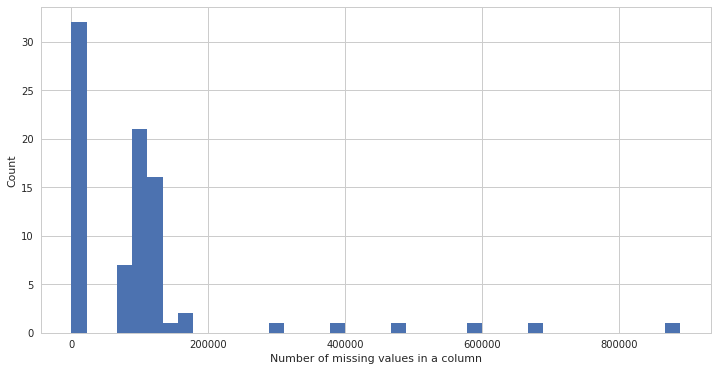

In [10]:
# I visualize the distribution of missing value counts to find the outliers - columns with a large share of missing values
plt.rcParams['figure.figsize'] = [12, 6]
plt.hist(missing_col, bins=40)
plt.xlabel("Number of missing values in a column")
plt.ylabel("Count")
plt.show()

In [11]:
# I simply sort the column with missing value counts per column to investigate 
# whether multiple attributes have the same amount of missing values

print(missing_data_stats['Total Missing'].sort_values(ascending=False))

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

In [12]:
#I decided to remove the columns that have more than 20% of missing values
removed_columns = missing_col[missing_col > int(0.2*azdias.shape[0])].index
print(removed_columns.tolist())
azdias_rmc = azdias.drop(removed_columns, axis=1)
print(azdias_rmc.shape)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
(891221, 79)


In [13]:
#I remove the 6 attributes also from the feature summary file
feat_info_rmc = feat_info[-feat_info.attribute.isin(removed_columns)]
print(feat_info_rmc.shape)

(79, 4)


#### Discussion 1.1.2: Assess Missing Data in Each Column


From the histogram that shows the distribution of missing value counts it is evident that there are some columns in the dataset with a relatively high proportion of missing values. The entire dataset consists of roughly 900 thousand rows, and we can see that there exists a column in the dataset for which almost all data is missing, as well as columns with 30%-80% of missing values. Based on the visualization, I have decided to set the threshold to 20% and remove from the dataset all the columns with a higher proportion of missing values. This resulted in 6 columns being removed from the dataset, namely AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP and KBA05_BAUMAX. 

The reduced dataset consists of 79 different columns. From the visualization above, and the printed tables, we can see that around 30 of the attributes have no (or very little) data missing. For all other columns, there can be some patterns observed in the amount of missing data, i.e. various columns share the same amount of missing values. For example, all the 7 attributes that start with "PLZ8" are missing precisely 116515 data entries, all the 6 "KBA05" attributes 133324 of them, variables MIN_GEBAEUDEJAHR, GEBAEUDETYP, WOHNLAGE, OST_WEST_KZ are all missing 93148 entries, etc. All these patterns are most likely due to the fact that many variables have been obtained from the same data source.

#### Step 1.1.3: Assess Missing Data in Each Row

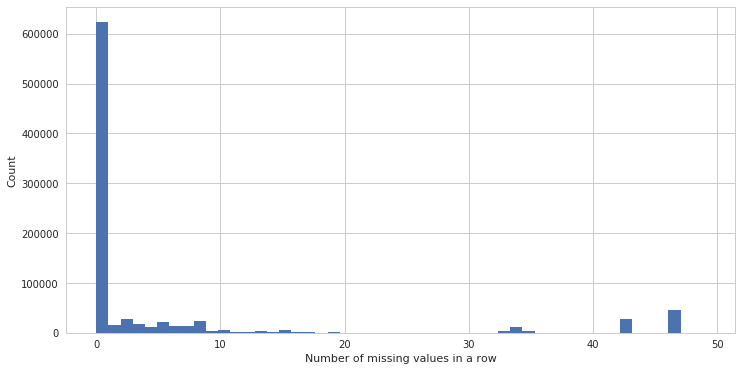

In [14]:
# First, I investigate how much data is missing in each row of the dataset
missing_row = azdias_rmc.isnull().sum(axis=1)
plt.hist(missing_row, bins=50)
plt.xlabel("Number of missing values in a row")
plt.ylabel("Count")
plt.show()

In [15]:
# I set the threshold for acceptable number of missing values per row to 10. I split the dataset 
# into two subsets based on the number of missing values in each row.
removed_rows = missing_row > 10
azdias_rmboth = azdias_rmc[-removed_rows]
azdias_outlier_rows = azdias_rmc[removed_rows]

print("Keep:",azdias_rmboth.shape)
print("Remove:",azdias_outlier_rows.shape)

Keep: (780153, 79)
Remove: (111068, 79)


In [16]:
# I compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# I write a function to make the comparison easier
def compare_dist(column):
    plt.subplot(1,2,1)
    plt.title('Distribution w/o outlier rows')
    sns.countplot(azdias_rmboth[column])
    plt.subplot(1,2,2)
    plt.title('Distribution in outlier rows')
    sns.countplot(azdias_outlier_rows[column])
    plt.show()

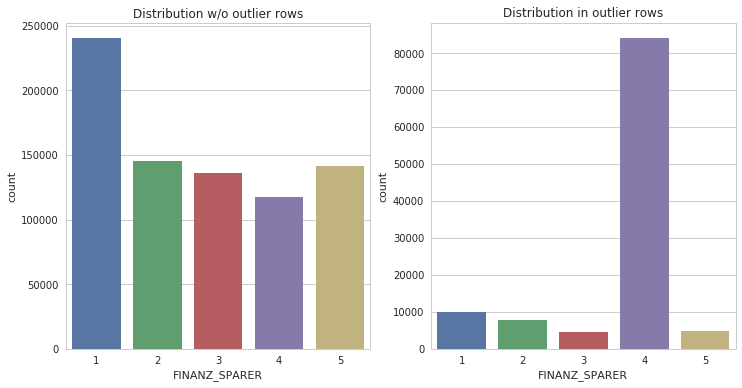

In [17]:
compare_dist('FINANZ_SPARER')

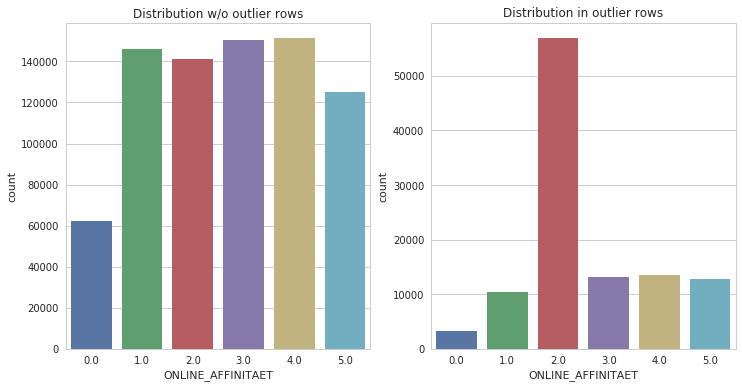

In [18]:
compare_dist('ONLINE_AFFINITAET')

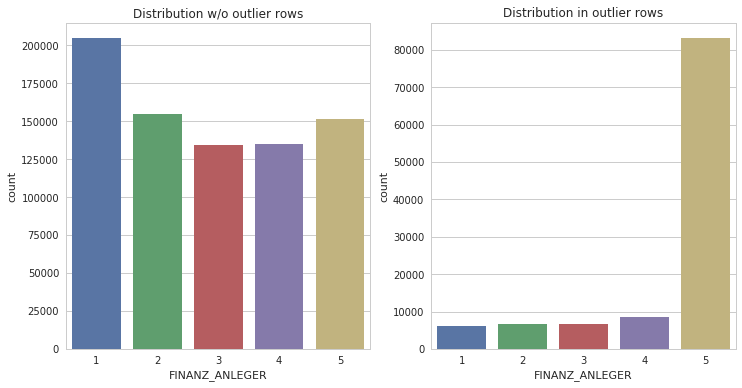

In [19]:
compare_dist('FINANZ_ANLEGER')

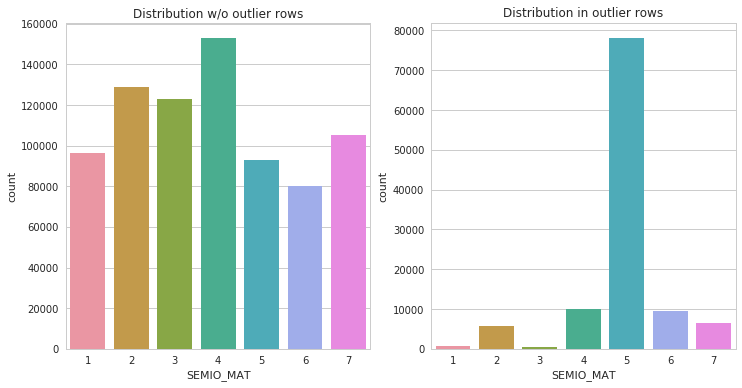

In [20]:
compare_dist('SEMIO_MAT')

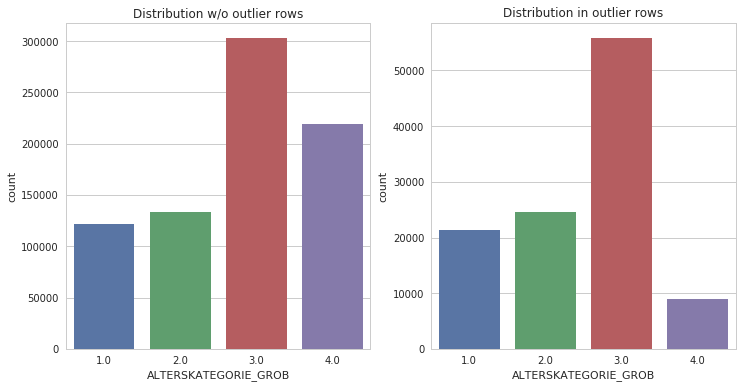

In [21]:
compare_dist('ALTERSKATEGORIE_GROB')

#### Discussion 1.1.3: Assess Missing Data in Each Row


From the histogram presented above it is evident that even after the outlier columns have been removed there are several rows in the dataset with a relatively high proportion of missing values. We can see from the plot that there are almost 100 thousand rows that are missing 30-50 values, which in relative terms equals to roughly 40%-60% of missing values in each row. I therefore split the dataset into two subsets: one that includes rows that have no or only few missing values, and one that stores the so-called outlier rows. By setting the threshold to 10 missing values per row, I keep in the main dataset around 780 thousand rows with no or only few missing values, and label the remaining 110 thousand rows as outlier rows.

I continue the analysis with the 'main' dataset, nevertheless, I cannot simply drop the outlier rows without analyzing them first. From the comparison above, performed by using the 'compare_dist' function, it is clear that the distributions of data values (on columns that are not missing much data) are very different between the main dataset and the set containing just outlier rows. Therefore, the outlier rows cannot be dropped altogether, but have to be stored as will represent a special data cluster later in the analysis.

### Step 1.2: Select and Re-Encode Features

In [22]:
# How many features are there of each data type?

# I work with the reduced dataset with columns and rows with missing values already removed
feat_info_rmc['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_vars = azdias_rmboth.columns[feat_info_rmc.type == 'categorical']
dict_cv = {}
multilevels = []
binary = []

for i in range(len(cat_vars)):
    dict_cv[cat_vars[i]] = azdias_rmboth[cat_vars[i]].dropna().unique().tolist()
    if len(azdias_rmboth[cat_vars[i]].dropna().unique().tolist()) >= 3:
        multilevels.append(cat_vars[i])
    else:
        binary.append(cat_vars[i])

print("Categorical variables:")
print(cat_vars.tolist(),'\n')
print('Multi-level categorical variables')
print(multilevels,'\n')
print('Binary categorical variables')
print(binary,'\n')
print('Values of binary categorical variables')
print({k:v for k,v in dict_cv.items() if k in binary})

Categorical variables:
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] 

Multi-level categorical variables
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] 

Binary categorical variables
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'] 

Values of binary categorical variables
{'ANREDE_KZ': [2, 1], 'GREEN_AVANTGARDE': [0, 1], 'SOHO_KZ': [1.0, 0.0], 'VERS_TYP': [2.0, 1.0], 'OST_WEST_KZ': ['W', 'O']}


In [24]:
# I remove some multilevel categorical variables and one-hot encode the rest.
# The justification is provided in the discussion below.
remove_multilevels = ['FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN','CAMEO_DEU_2015','GEBAEUDETYP']
azdias_rmboth_rmcat = azdias_rmboth.drop(remove_multilevels, axis=1)
print(azdias_rmboth_rmcat.shape)

(780153, 73)


In [25]:
cat_to_onehot = [elt for elt in multilevels if elt not in remove_multilevels]
for feature in cat_to_onehot:
    df_feature = pd.get_dummies(azdias_rmboth_rmcat[feature].astype('category'), dummy_na=True, 
                                prefix = feature, dtype ='int')
    #Keep the nans after the hot encoding
    df_feature.loc[df_feature.iloc[:,-1] == 1, : ] = np.nan
    add_df = df_feature.drop(df_feature.columns[-1],axis=1)
    azdias_rmboth_rmcat = pd.concat([azdias_rmboth_rmcat.drop(feature, axis=1),add_df], axis=1)

In [26]:
print("Size of the dataset after hot-encoding:")
print(azdias_rmboth_rmcat.shape)

Size of the dataset after hot-encoding:
(780153, 104)


In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.

# OST_WEST_KZ is the binary variable that needs to be re-encoded.
azdias_rmboth_rmcat['OST_WEST_KZ'].replace("W",0,inplace=True)
azdias_rmboth_rmcat['OST_WEST_KZ'].replace("O",1,inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features


As presented above the dataset consists (after removing 6 features due to high proportion of missing values) of 49 ordinal variables, 18 categorical variables, 6 numeric variables and 6 mixed-type variables. First of all, I keep the numeric variables intact. Similarly, I make a simplifying assumption that values of all ordinal variables are linear in spacing, and can be used in their original form. 

Such assumption can obviously not be applied to the categorical variables, as using the distance metric between different categories would not be very meaningful. As can be seen from the above there are 13 multi-level categorical variables in the dataset (CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015) and 5 binary variables (ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ). 

I have decided to keep some multi-level categorical variables in the dataset, as I believe they store valuable information that could be useful for the clustering analysis. Specifically, I have decided not to remove various person-level features, and rather one-hot encode them using the pandas 'get_dummies' function. This holds for the following 8 features: CJT_GESAMTTYP, LP_FAMILIE_GROB, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015. In this step I had to also make sure that the missing values in the original categorical variables are correctly reflected in the dummy coded features.

As mentioned, I have not performed the one-hot encoding for all the multi-level categorical variables in order not to increase the dimensionality of the dataset too much, as this could potentially harm the performance of the k-means clustering algorithm. For this exact reason, I have removed from the dataset the multi-level categorical variables with more than 10 categories: GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_STATUS_FEIN and CAMEO_DEU_2015. In the latter 3 cases the loss of information is not too drastic, as I have kept in the dataset the variables storing exact same information with less detailed breakdown (e.g. LP_FAMILIE_FEIN is just a more granular breakdown of LP_FAMILIE_GROB). I have also removed from the dataset the FINANZTYP and GEBAEUDETYP variables, as I believe there are other features in the dataset storing very similar information.
 
I have decided to keep all the binary categorical variables in the dataset. The ones with numeric values do not need any further transformation. It can be seen from the above analysis that there is one variable with non-numeric values, namely the OST_WEST_KZ. I have re-encoded it by simply replacing all the 'W' values with number 0, and all the 'O' values with number 1.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis.

In [28]:
mixed = feat_info_rmc.attribute[feat_info_rmc.type == 'mixed'].tolist()
print('Mixed-type features:')
print(mixed)

Mixed-type features:
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
pra_jug = azdias_rmboth_rmcat['PRAEGENDE_JUGENDJAHRE']

Original encoding of the 'PRAEGENDE_JUGENDJAHRE' (obtained from Data_Dictionary.md):
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [30]:
# I create a new binary variable that will represent the movement (mainstream vs. avantgarde)
# Number 0 will represent the category 'avantgarde', and number 1 the category 'mainstream'
movement = np.zeros(len(pra_jug))
movement[pra_jug.isnull()] = np.NaN
movement[pra_jug.isin([1,3,5,8,10,12,14])] = 1
azdias_rmboth_rmcat['PRAEGENDE_JUGENDJAHRE_movement'] = pd.Series(movement)

In [31]:
# I create an interval-type variable representing the generation by decade. 
# I use pandas Interval object to encode the information obtained from the original dataset.
# For all subsequent analyses the midpoint of each interval is calculated, as the clustering algorithm
# does not work with the pandas Interval object.
decade = np.zeros(len(pra_jug))
decade[pra_jug.isnull()] = np.NaN
decade_s = pd.Series(decade)
decade[pra_jug.isin([1,2])] = pd.Interval(40,50,'left').mid
decade[pra_jug.isin([3,4])] = pd.Interval(50,60,'left').mid
decade[pra_jug.isin([5,6,7])] = pd.Interval(60,70,'left').mid
decade[pra_jug.isin([8,9])] = pd.Interval(70,80,'left').mid
decade[pra_jug.isin([10,11,12,13])] = pd.Interval(80,90,'left').mid
decade[pra_jug.isin([14,15])] = pd.Interval(90,100,'left').mid
azdias_rmboth_rmcat['PRAEGENDE_JUGENDJAHRE_decade'] = pd.Series(decade)

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
cameo_intl = azdias_rmboth_rmcat['CAMEO_INTL_2015']

Original encoding of the 'CAMEO_INTL_2015' (obtained from Data_Dictionary.md):
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [33]:
# I create an ordinal variable (under our simplifying assumption actually a numeric variable) 
# representing individual's wealth (from 1-wealthy to 5-poor)
wealth = np.zeros(len(cameo_intl))
wealth[cameo_intl.isnull()] = np.NaN
wealth[cameo_intl.notnull()] = cameo_intl[cameo_intl.notnull()].astype(int)//10
azdias_rmboth_rmcat['CAMEO_INTL_2015_wealth'] = pd.Series(wealth)

# The second created variable is also ordinal and represents individual's life stage
# (1-Pre-Family Couples & Singles to 5-Elders in Retirement)
life_stage = np.zeros(len(cameo_intl))
life_stage[cameo_intl.isnull()] = np.NaN
life_stage[cameo_intl.notnull()]  = cameo_intl[cameo_intl.notnull()].astype(int)%10
azdias_rmboth_rmcat['CAMEO_INTL_2015_life_stage'] = pd.Series(life_stage)

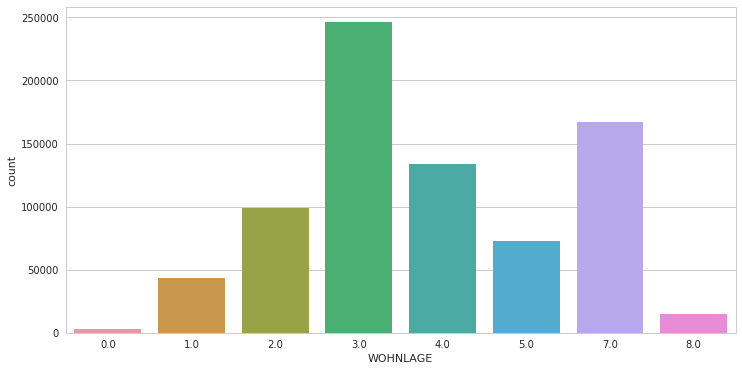

In [34]:
# Investigate "WOHNLAGE"
wohnlage = azdias_rmboth_rmcat['WOHNLAGE']
sns.countplot(wohnlage);

Original encoding of WOHNLAGE (obtained from the Data_Dictionary.md)
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

In [35]:
# From the information stored in the 'WOHNLAGE' variable I first wanted to create a variable 
# that represents the neighborhood quality. The problem is, however, that for a very large portion of the 
# data this information is not available, i.e. for all entries with categories 0,7 or 8.
wohnlage_rating = np.zeros(len(wohnlage))
wohnlage_rating[wohnlage == 0] = np.NaN
wohnlage_rating[wohnlage == 7] = np.NaN
wohnlage_rating[wohnlage == 8] = np.NaN
print(np.isnan(wohnlage_rating).sum())

185102


In [36]:
# Another feature that can be created from the 'WOHNLAGE' information is a binary variable indicating
# whether an individual's house is in a rural neighborhood (labels 7 and 8) or not.
wohnlage_rural = np.zeros(len(wohnlage))
wohnlage_rural[wohnlage.isnull()] = np.NaN
wohnlage_rural[wohnlage == 7] = 1
wohnlage_rural[wohnlage == 8] = 1

azdias_rmboth_rmcat['WOHNLAGE_rural'] = pd.Series(wohnlage_rural)

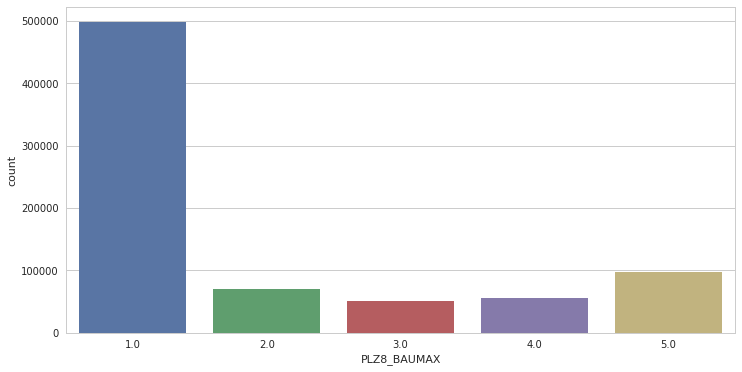

In [37]:
# Investigate 'PLZ8_BAUMAX'
plz8_baumax = azdias_rmboth_rmcat['PLZ8_BAUMAX']
sns.countplot(plz8_baumax);

Original encoding of the 'PLZ8_BAUMAX' (obtained from Data_Dictionary.md):
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

In [38]:
# From the information stored in the 'PLZ8_BAUMAX' variable I can first create a binary variable indicating whether
# in a given area there are mainly business buildings (5) or mainly family homes (1-4)
plz8_business = np.zeros(len(plz8_baumax))
plz8_business[plz8_baumax.isnull()] = np.NaN
plz8_business[plz8_baumax == 5] = 1

azdias_rmboth_rmcat['PLZ8_BAUMAX_business'] = pd.Series(plz8_business)

In [39]:
# I can also engineer an ordinal variable that represents the size of family homes in a given area.
# For this purpose, I will treat all the entries with label 5: "mainly business buildings" as non-available.

plz8_family = plz8_baumax.copy()
plz8_family[plz8_family == 5] = np.NaN

azdias_rmboth_rmcat['PLZ8_BAUMAX_family'] = pd.Series(plz8_family)

#### Discussion 1.2.2: Engineer Mixed-Type Features


As investigated above, there are 6 different mixed-type variables in the analyzed set: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, WOHNLAGE, CAMEO_INTL_2015 and PLZ8_BAUMAX.

I have first familiarized myself with the original encoding of the **PRAEGENDE_JUGENDJAHRE** variable (also presented above), by reading the specifications in the 'Data_Dictionary' file. I re-engineered the feature by creating two new variables. First is a binary variable with numerical 0 and 1 values that represent the avantgarde and mainstream movement, respectively.

The second created variable is an interval-type variable representing the generation by decade. I used pandas Interval object to encode the information obtained from the original dataset. As the pandas Interval object cannot be used in the clustering algorithm, I have represented each interval with its midpoint, which is a numeric value.

As instructed, I have also re-engineered the **CAMEO_INTL_2015** variable that combines information on two attributes, wealth and life stage. I broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal/numeric variables (in this project we assume the ordinal variables are linear in spacing). The 'tens'-place represents household's wealth and has been obtained from the original code simply by performing integer division by 10. The new variable takes values from 1 (representing Wealthy Households) to 5 (Poorer Households). The 'ones'-place represents the household's life stage and has been calculated as mod 10 of the original code. The new variable takes values from 1 (representing Pre-Family Couples & Singles) to 5 (representing Elders In Retirement).

From the information stored in the **WOHNLAGE** variable I first wanted to create an ordinal variable that represents the neighborhood quality. The problem is, however, that for a very large portion of the data the information is not available. For all data points with labels 0, 7 and 8 it is impossible to infer the quality of the neighborhood. I have inspected how much data is actually missing for this feature and it is well above the threshold specified earlier in this project. Therefore, I have decided not to include this newly created variable in the dataset.

Another feature that can be created from the WOHNLAGE information is a variable indicating whether an individual's house is in a rural neighborhood or not. I have created a binary variable where 1 represents a rural neighborhood (labels 7 and 8 in the original dataset) and 0 an urban neighborhood (all other labels).

From the information stored in the **PLZ8_BAUMAX** variable I have first created a binary variable that indicates whether a given area consists of mainly business buildings (all entries with original category 5 are assigned a new binary value 1) or mainly family homes (all entries with original categories 1-4 are assigned a new binary value 0). 

I have also created an ordinal variable that represents the size of family homes in a given area. For this purpose, I have treated all the entries with category 5("mainly business buildings") as non-available, while keeping all other values intact.

I have decided to remove both **LP_LEBENSPHASE_FEIN** and **LP_LEBENSPHASE_GROB** mixed-type variables from the dataset, as the potential re-engineered variables would contain similiar information to features that are already included in the dataset, e.g. LP_FAMILIE_GROB and LP_STATUS_GROB.

In [41]:
#The only thing left to do is removing the original mixed-type features.
azdias_clean = azdias_rmboth_rmcat.drop(mixed, axis=1)
print(azdias_clean.shape)

(780153, 105)


### Step 1.3: Create a Cleaning Function

With the above steps we cleaned the general population demographics data, but it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. Therefore, we combine all the main steps (feature selection, encoding, re-engineering) in the function below.

In [42]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    for i in range(df.shape[1]):
        att_code = feat_info['missing_or_unknown'][i]
        if att_code == '[]':
            continue
        else:
            att_code = att_code.replace('[','').replace(']','').split(',')
            att_code_tr = []
            count_unknown_col = 0
            for elt in att_code:
                try:
                    att_code_tr.append(int(elt))
                except:
                    att_code_tr.append(elt)      
            df.iloc[:,i].replace(att_code_tr, np.NaN, inplace=True)
    
    
    df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 
             'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1, inplace=True)
      
    missing_row = df.isnull().sum(axis=1)    
    remove_rows = missing_row > 10
    
    df.drop(['FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN',
             'CAMEO_DEU_2015','GEBAEUDETYP'], axis=1, inplace=True)
    
    cat_to_onehot = ['CJT_GESAMTTYP','LP_FAMILIE_GROB','LP_STATUS_GROB',
                     'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','CAMEO_DEUG_2015']
    for feature in cat_to_onehot:
        df_feature = pd.get_dummies(df[feature].astype('category'), dummy_na=True, 
                                    prefix = feature, dtype ='int')
        df_feature.loc[df_feature.iloc[:,-1] == 1, : ] = np.nan
        add_df = df_feature.drop(df_feature.columns[-1],axis=1)
        df = pd.concat([df.drop(feature, axis=1),add_df], axis=1)
    
    df['OST_WEST_KZ'].replace("W",0,inplace=True)
    df['OST_WEST_KZ'].replace("O",1,inplace=True)
    
    pra_jug=df['PRAEGENDE_JUGENDJAHRE']
    movement = np.zeros(len(pra_jug))
    movement[pra_jug.isnull()] = np.NaN
    movement[pra_jug.isin([1,3,5,8,10,12,14])] = 1
    df['PRAEGENDE_JUGENDJAHRE_movement'] = pd.Series(movement)
    
    decade = np.zeros(len(pra_jug))
    decade[pra_jug.isnull()] = np.NaN
    decade_s = pd.Series(decade)
    decade[pra_jug.isin([1,2])] = pd.Interval(40,50,'left').mid
    decade[pra_jug.isin([3,4])] = pd.Interval(50,60,'left').mid
    decade[pra_jug.isin([5,6,7])] = pd.Interval(60,70,'left').mid
    decade[pra_jug.isin([8,9])] = pd.Interval(70,80,'left').mid
    decade[pra_jug.isin([10,11,12,13])] = pd.Interval(80,90,'left').mid
    decade[pra_jug.isin([14,15])] = pd.Interval(90,100,'left').mid
    df['PRAEGENDE_JUGENDJAHRE_decade'] = pd.Series(decade)
    
    cameo_intl=df['CAMEO_INTL_2015']
    
    wealth = np.zeros(len(cameo_intl))
    wealth[cameo_intl.isnull()] = np.NaN
    wealth[cameo_intl.notnull()] = cameo_intl[cameo_intl.notnull()].astype(int)//10
    df['CAMEO_INTL_2015_wealth'] = pd.Series(wealth)

    life_stage = np.zeros(len(cameo_intl))
    life_stage[cameo_intl.isnull()] = np.NaN
    life_stage[cameo_intl.notnull()]  = cameo_intl[cameo_intl.notnull()].astype(int)%10
    df['CAMEO_INTL_2015_life_stage'] = pd.Series(life_stage)

    wohnlage = df['WOHNLAGE']
    wohnlage_rural = np.zeros(len(wohnlage))
    wohnlage_rural[wohnlage.isnull()] = np.NaN
    wohnlage_rural[wohnlage == 7] = 1
    wohnlage_rural[wohnlage == 8] = 1
    df['WOHNLAGE_rural'] = pd.Series(wohnlage_rural)
    
    plz8_baumax = df['PLZ8_BAUMAX']
    plz8_business = np.zeros(len(plz8_baumax))
    plz8_business[plz8_baumax.isnull()] = np.NaN
    plz8_business[plz8_baumax == 5] = 1
    df['PLZ8_BAUMAX_business'] = pd.Series(plz8_business)
    
    plz8_family = plz8_baumax.copy()
    plz8_family[plz8_family == 5] = np.NaN
    df['PLZ8_BAUMAX_family'] = pd.Series(plz8_family)
    
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 
             'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'], axis=1, inplace=True)

    #Storing the information about removed rows comes in handy when defining one extra cluster
    #for data with a high proportion of missing values
    return(df[-remove_rows], remove_rows)    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [43]:
#I perform the scaling before the imputation. I have to do the process manually, since the respective scaling functions
#in sklearn cannot handle missing values.

azdias_sc = pd.DataFrame()

#I have to save the scaling parameters so I can use them on other datasets later in the project
scaling_mus = []
scaling_sigmas = []

for i in range(azdias_clean.shape[1]):
    mu = azdias_clean.iloc[:,i].mean(skipna=True)
    scaling_mus.append(mu)
    sd = azdias_clean.iloc[:,i].std(skipna=True)
    scaling_sigmas.append(sd)
    azdias_sc[azdias_clean.columns[i]]=(azdias_clean.iloc[:,i]-mu)/sd

In [44]:
# I apply the mean imputation. As it is performed after the features are already standardized (mean=0) I can just simply
# replace the missing values with zeros.

azdias_sc.fillna(0, inplace=True)

### Discussion 2.1: Apply Feature Scaling


I have decided to first perform the scaling on the non-missing values and then perform the imputation by simply filling all the missing values with the mean of the respective standardized feature. Missing values are thus filled with zeros, since after standardization this is the mean of each transformed feature. I believe this approach is more appropriate than for example the reverse process when first the imputation is done and only then the features are scaled. In this second approach the calculated scaling variance can be significantly lowered due to imputation and this can artificially increase the (transformed) distances in the non-missing data. This approach is thus obviously sensitive to the amount of missing data (unlike the approach I have picked). 

It has to be mentioned, however, that by imputing after scaling, the variance of the transformed feature will in some cases not be equal to one, but can be slightly smaller in cases where missing values were present. This means that when performing the dimensionality reduction the PCA algorithm will give slightly more weight to the variables with less missing data, which actually does not seem problematic at all. In any case, all the above-described effects should not drastically impact the subsequent analysis, as the amount of missing data in the cleaned dataset is rather low.

I have chosen the mean imputation also because in this project we are treating all the features as if they were numeric. This holds for all the binary variables (original binary and one-hot encoded multi-level categorical variables), as well as for ordinal variables, for which it is assumed that they are linear in spacing.

### Step 2.2: Perform Dimensionality Reduction

On the scaled data we can then apply dimensionality reduction techniques.

In [45]:
# Apply PCA to the data.
pcamodel = PCA()
pcamodel.fit(azdias_sc);

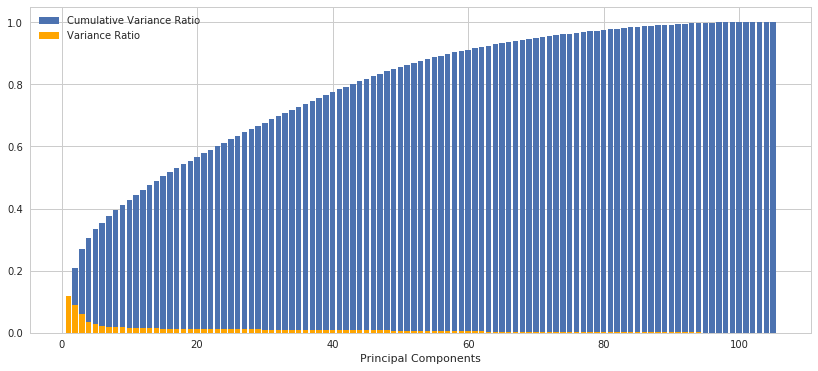

In [46]:
# Investigate the variance accounted for by each principal component.
ratios = pcamodel.explained_variance_ratio_
c_ratios = ratios.cumsum()

plt.rcParams['figure.figsize'] = [14,6]
plt.bar(range(1,len(c_ratios)+1),c_ratios)
plt.bar(range(1,len(ratios)+1),ratios,color='orange')
plt.xlabel('Principal Components')
plt.legend(['Cumulative Variance Ratio','Variance Ratio'])
plt.show()

In [47]:
n_pcomp = [i for i,c in enumerate(c_ratios) if c > 0.8 ][0]+1
print(n_pcomp)

43


In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pcamodel2 = PCA(n_components=n_pcomp)
pcamodel2.fit(azdias_sc)
azdias_tr = pcamodel2.transform(azdias_sc)

In [49]:
azdias_tr.shape

(780153, 43)

### Discussion 2.2: Perform Dimensionality Reduction


I have decided to retain the first 43 principal components, as they explain more than 80% of the variance in the analyzed dataset. It can also be seen from the plot depicting the cumulative variance ratios, that after first 40-50 principal components the curve flattens as the marginal contribution of each successive principal component gets smaller and smaller. With the transformation I reduce the dimensionality of the dataset from 105 features to 43 features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_names = azdias_sc.columns.tolist()

In [51]:
# For a given principal component the function returns a list of weights with corresponding feature names,
# and is sorted wrt the weights. The function also returns a barplot that visualizes the most 
# prominent features for each pc, i.e. the ones with largest and smallest n weights.

def investigate(pcamodel, feature_names, i, print_list=True, n_plot=5):
    principal_components = pcamodel.components_
    weights = principal_components[i-1,:]
    order = weights.argsort()
    weights_ordered= [weights[j] for j in order]
    names_ordered = [feature_names[k] for k in order]
    
    if print_list:
        print(pd.DataFrame({"Weights":weights_ordered,"Features":names_ordered}))
    else:
        sns.set(style="whitegrid")
        sns.barplot(weights_ordered[0:n_plot]+weights_ordered[-n_plot:],
                    names_ordered[0:n_plot]+names_ordered[-n_plot:],orient='h',palette="RdBu")
        plt.xlabel("Weight")

In [52]:
# Feature weights of the first principal component
investigate(pcamodel2, feature_names, 1)

      Weights                        Features
0   -0.227530                      MOBI_REGIO
1   -0.213280                      PLZ8_ANTG1
2   -0.212073                     KBA05_ANTG1
3   -0.206525               FINANZ_MINIMALIST
4   -0.204270                       KBA05_GBZ
5   -0.158209                     KONSUMNAEHE
6   -0.157883                        PLZ8_GBZ
7   -0.155630                      INNENSTADT
8   -0.127259              LP_STATUS_GROB_4.0
9   -0.119678                        BALLRAUM
10  -0.115354              LP_STATUS_GROB_5.0
11  -0.108676              GEBAEUDETYP_RASTER
12  -0.105227                    ZABEOTYP_1.0
13  -0.103561                GREEN_AVANTGARDE
14  -0.093904            ALTERSKATEGORIE_GROB
15  -0.092676               CAMEO_DEUG_2015_2
16  -0.091229                FINANZ_VORSORGER
17  -0.086889                    ANZ_PERSONEN
18  -0.080659               CAMEO_DEUG_2015_4
19  -0.072824                KBA13_ANZAHL_PKW
20  -0.069867               CAMEO_

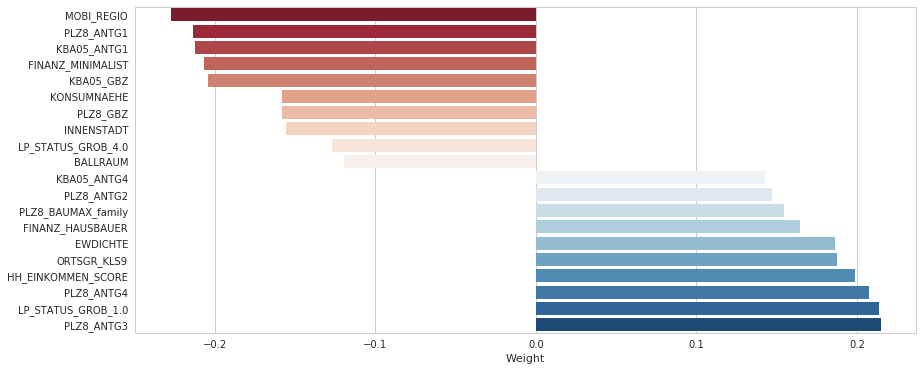

In [53]:
# Feature weights of the first principal component
investigate(pcamodel2, feature_names, 1, False, 10)

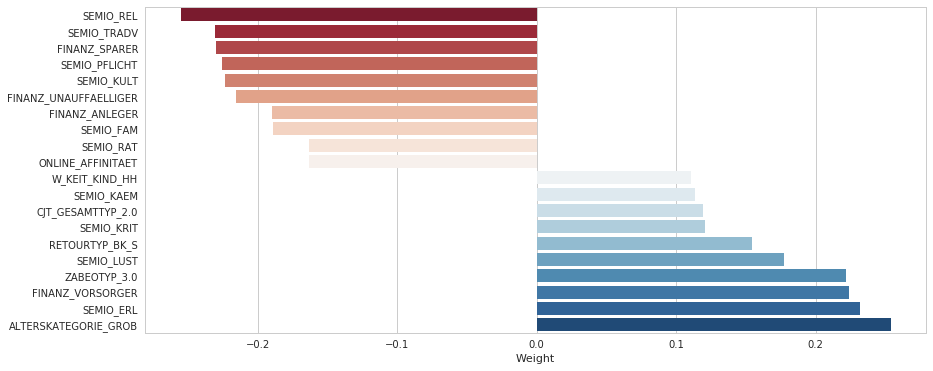

In [54]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# I only present the barplot with most prominent features and not the full list
investigate(pcamodel2, feature_names, 2, False, 10)

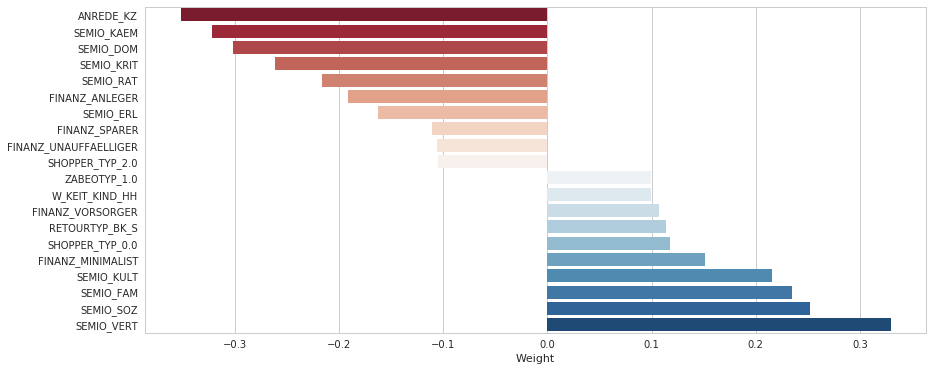

In [55]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
investigate(pcamodel2, feature_names, 3, False, 10)


### Discussion 2.3: Interpret Principal Components


#### 1st Principal Component
The most prominent features that constitute the first principal component are in general features that describe individual's living conditions, including the region of residence, the housing situation, as well as income. 

The most negative weight corresponds to the MOBI_REGIO feature representing the movement patterns in the region of individual's residence (the higher the score the lower the movement), followed by the PLZ8_ANTG1 and KBA05_ANTG1 variables that represent the share of 1-2 family houses in the region and microcell, respectively. Significant negative weights are associated with other variables describing the region of individual's residence, such as PLZ8_GBZ and KBA05_GBZ variables representing the number of buildings in the region/microcell, INNENSTADT representing the distance to the city centre, and also with building-level features, such as KONSUMNAEHE representing the distance from the building to the first point of sale. The two personal-level features with significant negative weights are the FINANZ MINIMALIST variable representing the level of financial interest, and binary LP_STATUS_GROB_4 indicating whether an individual is a homeowner (1) or not (0). High values in the above listed variables are typical for wealthier individuals, potentially homeowners, who live outside dense urban areas.

The significant positive weights again correspond mainly to region-type variables, such as PLZ8_ANTG3 and PLZ8_ANTG4 that represent the share of 6-10 and 10+ family houses, respectively. Similarly, the ORTSGR_KLS9 represents the size of the community, and EWDICHTE the density of houses in the region of individual's residence. The most prominent personal-level feature with a positive weight is the binary LP_STATUS_GROB_1 indicating low-income earners. This holds also for the HH_EINKOMMEN_SCORE variable, as it takes higher values for households with lower income. High values in the variables associated with positive weights in the first principal component are typical for individuals with lower income residing in urban areas.

#### 2nd Principal Component
The most prominent features that constitute the second principal component are in general personal-level features that describe individual's age, personality traits, views and beliefs, financial behaviour, consumption patterns, etc.

The most negative weight corresponds to the SEMIO_REL feature representing the individual's affinity to religion (the higher the value the lower the affinity), followed by SEMIO_TRADV representing individual's affinity to traditional values. Similarly, significant negative weights correspond to SEMIO_PFLICHT, SEMIO_KULT, SEMIO_FAM and SAMIO_RAT features representing individual's affinity to be dutiful, cultural, family-minded and rational, respectively. The other group of features with significant negative weights concern individual's financial behaviour, e.g. FINANZ_SPARER representing the level of saving (higher score represents low affinity to saving), or FINANZ ANLEGER representing the level of investing (higher score represents low affinity to investing). High values in the above listed variables are typical for (younger) individuals who do not have a strong affinity to religion, traditional values, are not family-minded, are not concerned with saving or investing.

The most positive weight corresponds to the ALTERSKATEGORIE_GROB feature representing individual's estimated age. Similar to above, many of the prominent features describe individual's personality traits. SEMIO_ERL represents individuals event-orientedness, SEMIO_LUST sensual-mindedness, SEMIO_KRIT critical-mindedness, etc. A large positive weight corresponds also to the group of features describing the individual's shopping patterns. RETOURTYP_BK_5 feature stores information on how  influenceable the individual is (the higher the score the less influenceable), whereas the binary CJT_GESAMTTYP_2 indicates consumption traditionalists. Higher values in the variables associated with positive weights in the second principal component are typical for older individuals who are also less out-going, less critical and sensual, and in general more traditional and conservative, also in terms of their financial behaviour and consumption patterns.


#### 3rd Principal Component
The most prominent features that constitute the third principal component are in general personal-level features that describe individual's gender, personality traits, financial behaviour, etc. The interpretation of the third principal component is not as straight-forward as was the case with the first two principal components.

The most significant negative weight corresponds to the ANREDE_KZ feature representing individual's gender. Large negative weights correspond also to various personal-level features such as SEMIO_KAEM representing individual's combative attitude, SEMIO_DOM representing individual's dominant-mindedness, etc. High values in these variables indicate female individuals who are less combative and less dominant-minded.

Also the prominent positive weights are associated with features describing individual's personality type. By far the most significant is the SEMIO_VERT feature that represents individual's dreamfulness, followed by SEMIO_SOZ representing individual's social-mindedness, SEMIO_FAM representing individual's family mindedness, etc. High values in these features indicate (male) individuals who are less dreamful, less social-minded and less family-minded.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [179]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
max_clusters = 30
#Save average distance scores in a list
scores = []
for k in range(1,15):
    start = time.time()
    kmeans = KMeans(k)
    kmeans.fit(azdias_tr)
    score = abs(kmeans.score(azdias_tr))
    scores.append(score)
    end = time.time()
    print(f"K={k}; Running Time: {end-start:.2f}")

K=1; Running Time: 7.87
K=2; Running Time: 28.14
K=3; Running Time: 54.60
K=4; Running Time: 44.87
K=5; Running Time: 70.46
K=6; Running Time: 87.25
K=7; Running Time: 100.79
K=8; Running Time: 140.93
K=9; Running Time: 141.66
K=10; Running Time: 175.32
K=11; Running Time: 203.94
K=12; Running Time: 242.86
K=13; Running Time: 281.98
K=14; Running Time: 211.55


In [180]:
for k in range(15,24):
    start = time.time()
    kmeans = KMeans(k)
    kmeans.fit(azdias_tr)
    score = abs(kmeans.score(azdias_tr))
    scores.append(score)
    end = time.time()
    print(f"K={k}; Running Time: {end-start:.2f}")

K=15; Running Time: 268.72
K=16; Running Time: 373.00
K=17; Running Time: 352.41
K=18; Running Time: 427.64
K=19; Running Time: 447.81
K=20; Running Time: 425.20
K=21; Running Time: 460.35
K=22; Running Time: 487.09
K=23; Running Time: 544.25


In [181]:
for k in range(24,max_clusters+1):
    start = time.time()
    kmeans = KMeans(k)
    kmeans.fit(azdias_tr)
    score = abs(kmeans.score(azdias_tr))
    scores.append(score)
    end = time.time()
    print(f"K={k}; Running Time: {end-start:.2f}")

K=24; Running Time: 519.68
K=25; Running Time: 557.70
K=26; Running Time: 523.26
K=27; Running Time: 747.77
K=28; Running Time: 676.41
K=29; Running Time: 653.87
K=30; Running Time: 662.97


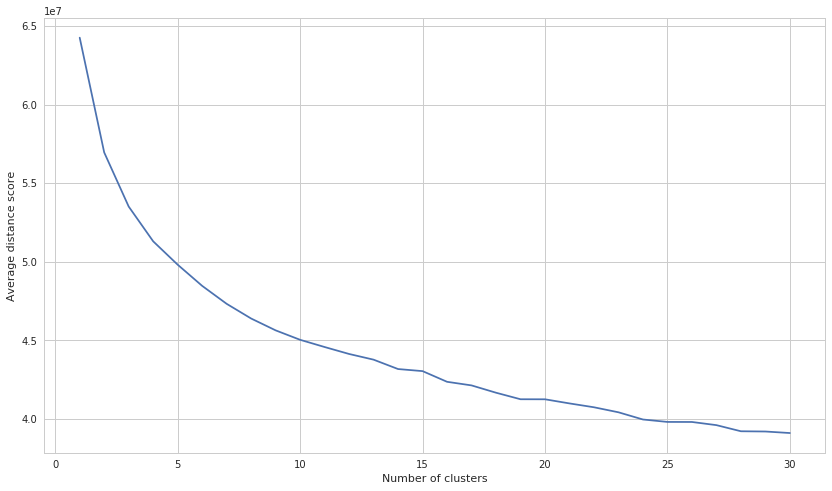

In [196]:
# Investigate the change in within-cluster distance across number of clusters.

plt.plot(range(1,31),scores)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance score')
plt.show()


In [56]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_final = KMeans(12, random_state=100)
kmeans_final.fit(azdias_tr)
cluster_labels = kmeans_final.predict(azdias_tr)
cl_general = pd.Series(cluster_labels)

### Discussion 3.1: Apply Clustering to General Population

I have performed the k-means clustering on the PCA-transformed dataset for different number of clusters, specifically k=1,2,...30. I used the elbow method on the above-presented scree plot from which it is clear that shortly after k=10 the curve slowly becomes flatter, as the net benefit of each additional cluster becomes smaller and smaller. Based on that I have decided to segment the population in 12 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We use the fitted objects from the general population to clean, transform, and cluster the customer data. In the last step of the project, we interpret how the general population fits apply to the customer data.

In [57]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')


In [58]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data
customers_clean, customers_removed_rows = clean_data(customers)
customers_clean.shape

(139068, 105)

In [59]:
customers_sc = pd.DataFrame()
for i in range(customers_clean.shape[1]):
    customers_sc[customers_clean.columns[i]]=(customers_clean.iloc[:,i]-scaling_mus[i])/scaling_sigmas[i]
#Using the same imputation as for the general population (i.e. mean imputation on the already scaled data, 
#hence filling with zeros)
customers_sc.fillna(0, inplace=True)

In [60]:
customers_tr = pcamodel2.transform(customers_sc)
cluster_labels_customers = kmeans_final.predict(customers_tr)
cl_customers = pd.Series(cluster_labels_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [61]:
# Number of rows that have been removed from the analysis, for both the general population and customers dataset.
# In 1.1.3 we have observed that the removed data is qualitatively different and is thus treated as an additional cluster.
# I assume the same holds also for the customers dataset.
nrr_general = sum(removed_rows)
nrr_customers = sum(customers_removed_rows)

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

rel_general_missing = nrr_general/(cl_general.count()+nrr_general)
rel_customers_missing = nrr_customers/(cl_customers.count()+nrr_customers)

rel_general = cl_general.value_counts()/(cl_general.count()+nrr_general)
rel_customers = cl_customers.value_counts()/(cl_customers.count()+nrr_customers)

#Index 9999 will represent the cluster with missing values
rel_general.at[9999] = rel_general_missing
rel_customers.at[9999] = rel_customers_missing

results = pd.DataFrame({"General Population": rel_general.sort_index(), "Customer Population":rel_customers.sort_index()})
print(results)

      General Population  Customer Population
0               0.070602             0.042342
1               0.075818             0.063250
2               0.070810             0.005552
3               0.066888             0.047701
4               0.076593             0.051249
5               0.062267             0.240858
6               0.076884             0.122028
7               0.058576             0.080083
8               0.063507             0.012351
9               0.068826             0.042290
10              0.095790             0.007503
11              0.088814             0.010420
9999            0.124625             0.274372


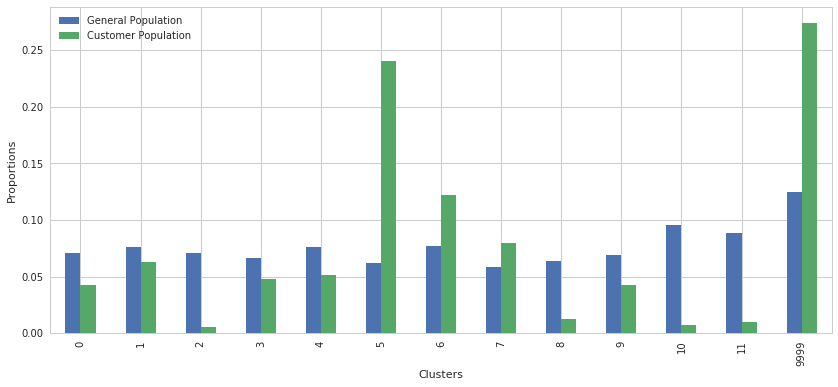

In [63]:
results.plot(kind="bar");
plt.xlabel("Clusters");
plt.ylabel("Proportions");

In [64]:
def analyzecluster(cluster_n):
    # Compare cluster vs population distribution for first 3 PCs, on both customers and general dataset
    customers_cluster = customers_tr[cluster_labels_customers==cluster_n]
    general_cluster = azdias_tr[cluster_labels==cluster_n]
    plt.rcParams['figure.figsize'] = [14,8]
    for i in range(3):
        plt.subplot(2, 3, i+1)
        sns.distplot(customers_cluster[:,i])
        sns.distplot(customers_tr[:,i])
        plt.title("PC"+str(i+1)+"(customers)")
        plt.legend(["Cluster","Population"])
    for i in range(3):
        plt.subplot(2, 3, 4+i)
        sns.distplot(general_cluster[:,i])
        sns.distplot(azdias_tr[:,i])
        plt.title("PC"+str(i+1)+"(general)")
        plt.legend(["Cluster","Population"])
    plt.show()
    
    # Compare cluster vs population distribution for 6 prominent variables in the original space, 
    # on both customers and general dataset

    #Inverse transformation
    general_inv = pcamodel2.inverse_transform(azdias_tr)
    customers_inv = pcamodel2.inverse_transform(customers_tr)
    general_inv_desc = pd.DataFrame()
    customers_inv_desc = pd.DataFrame()

    for i in range(general_inv.shape[1]):
        general_inv_desc[azdias_clean.columns[i]] = general_inv[:,i]*scaling_sigmas[i]+scaling_mus[i]
        customers_inv_desc[customers_clean.columns[i]] = customers_inv[:,i]*scaling_sigmas[i]+scaling_mus[i]
        
    customers_cluster2 = customers_inv_desc[cluster_labels_customers==cluster_n]
    general_cluster2 = general_inv_desc[cluster_labels==cluster_n]
    
    prom_features = ['HH_EINKOMMEN_SCORE','ANREDE_KZ','KBA05_ANTG1']
    
    for i in range(3):
        plt.subplot(2, 3, i+1)
        sns.distplot(customers_cluster2[prom_features[i]])
        sns.distplot(customers_inv_desc[prom_features[i]])
        plt.title(prom_features[i]+"(customers)")
        plt.legend(["Cluster","Population"])
        plt.xlabel("")
    for i in range(3):
        plt.subplot(2, 3, 4+i)
        sns.distplot(general_cluster2[prom_features[i]])
        sns.distplot(general_inv_desc[prom_features[i]])
        plt.title(prom_features[i]+"(general)")
        plt.legend(["Cluster","Population"])
        plt.xlabel("")
    plt.show()
    
    prom_features2 = ['ALTERSKATEGORIE_GROB','SEMIO_TRADV','FINANZ_ANLEGER']
    
    for i in range(3):
        plt.subplot(2, 3, i+1)
        sns.distplot(customers_cluster2[prom_features2[i]])
        sns.distplot(customers_inv_desc[prom_features2[i]])
        plt.title(prom_features2[i]+"(customers)")
        plt.legend(["Cluster","Population"])
        plt.xlabel("")
    for i in range(3):
        plt.subplot(2, 3, 4+i)
        sns.distplot(general_cluster2[prom_features2[i]])
        sns.distplot(general_inv_desc[prom_features2[i]])
        plt.title(prom_features2[i]+"(general)")
        plt.legend(["Cluster","Population"])
        plt.xlabel("")
    plt.show()
    

## Overrepresented Cluster 5

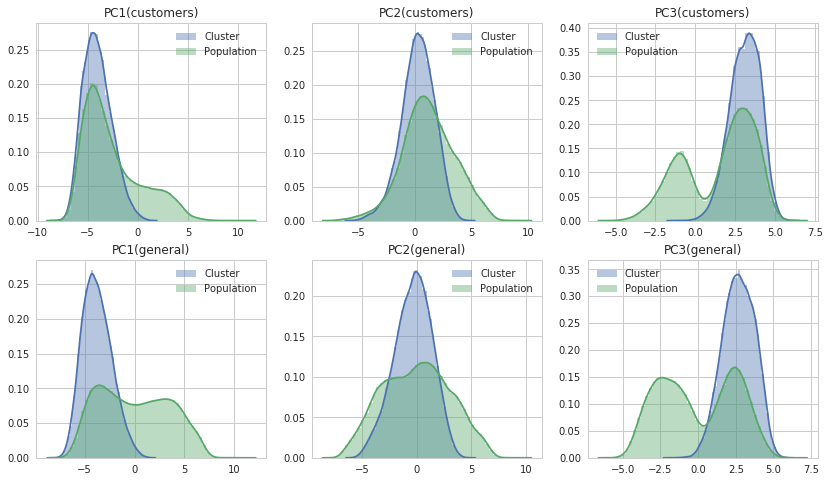

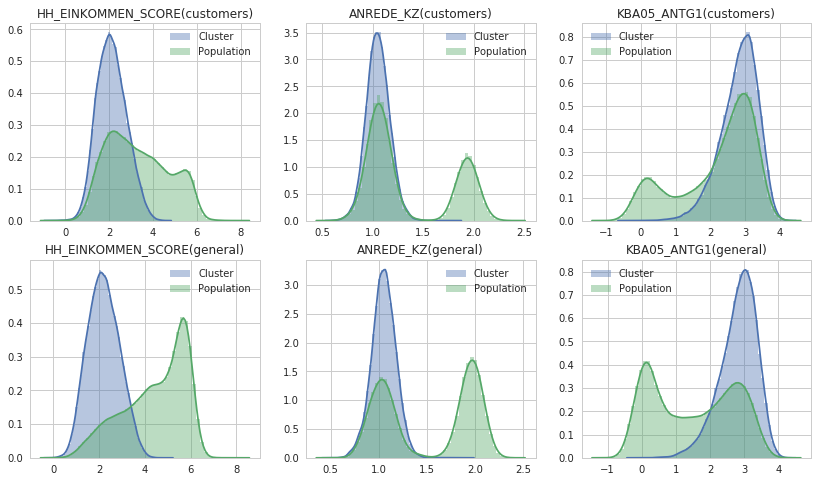

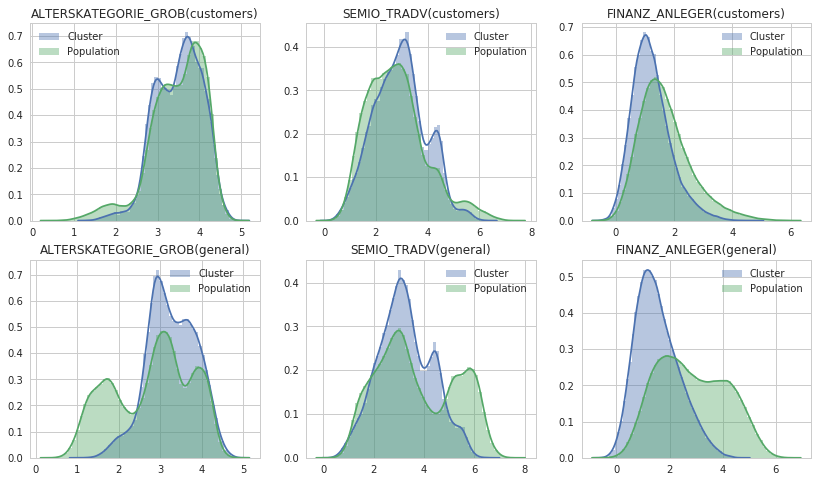

In [65]:
analyzecluster(5)

## Overrepresented Cluster 6

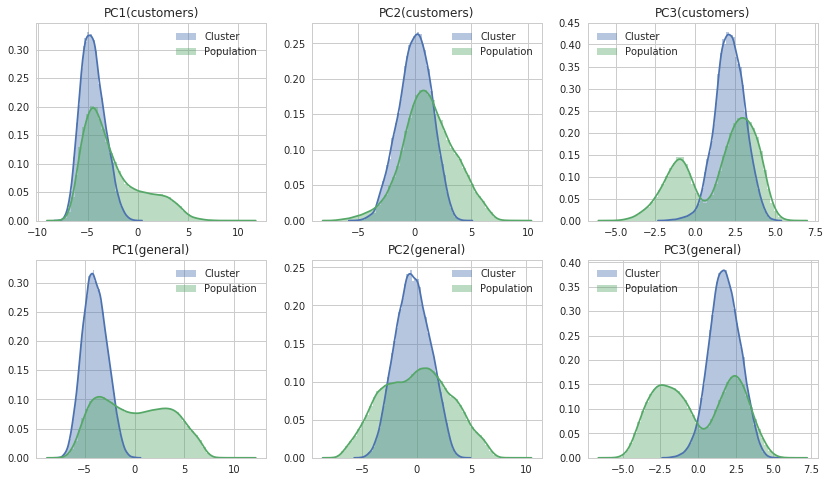

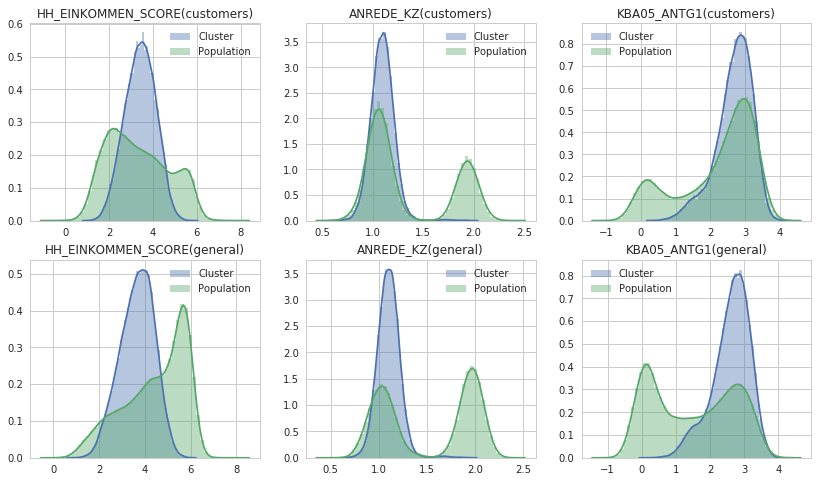

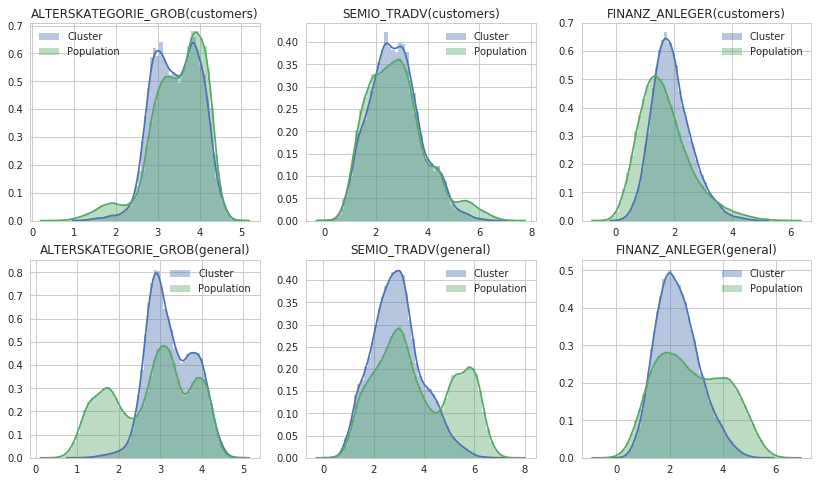

In [66]:
analyzecluster(6)

## Underrepresented Cluster 10

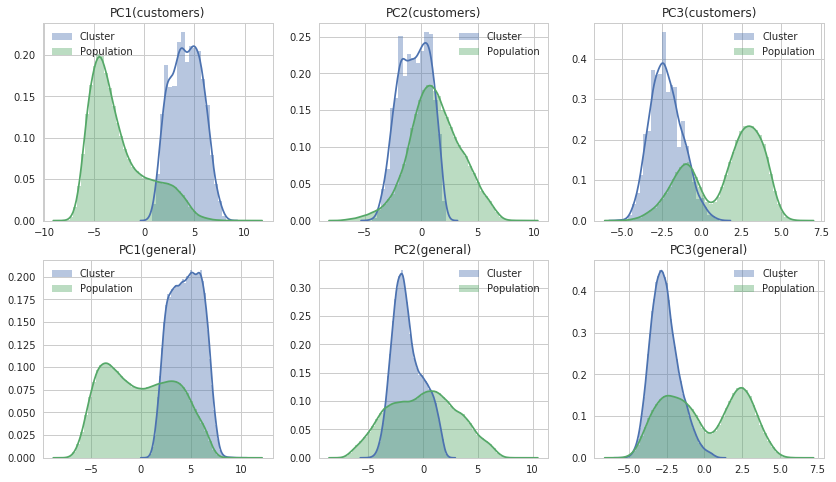

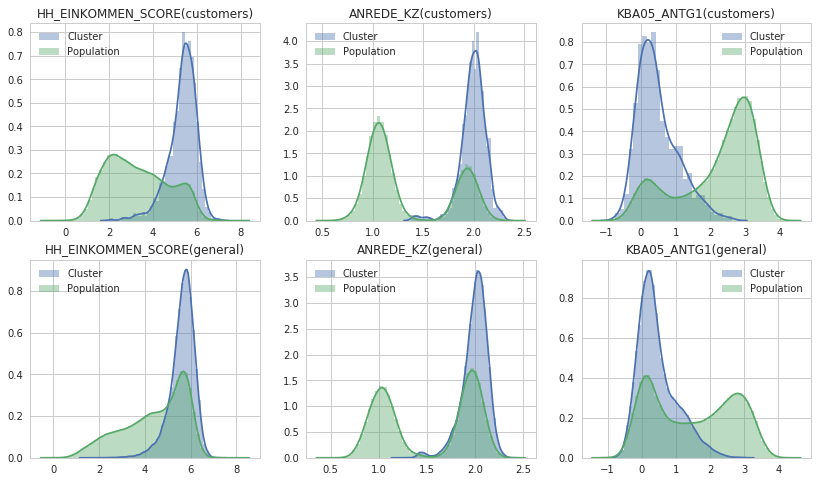

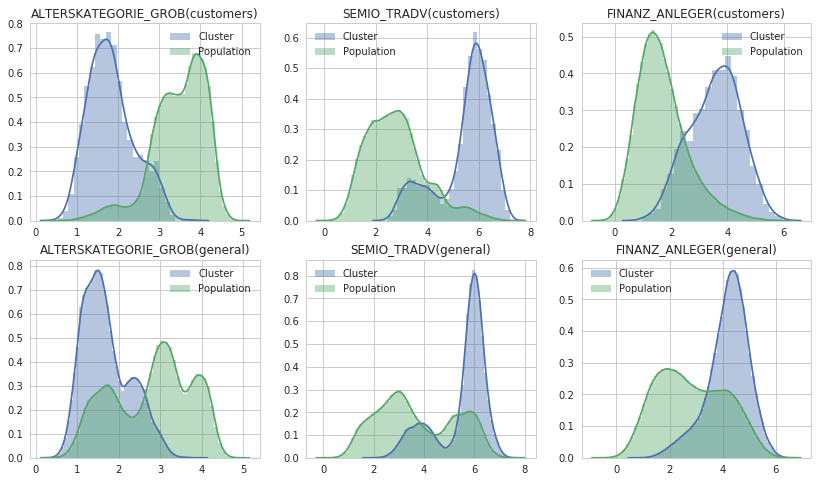

In [67]:
analyzecluster(10)

## Underrepresented Cluster 11

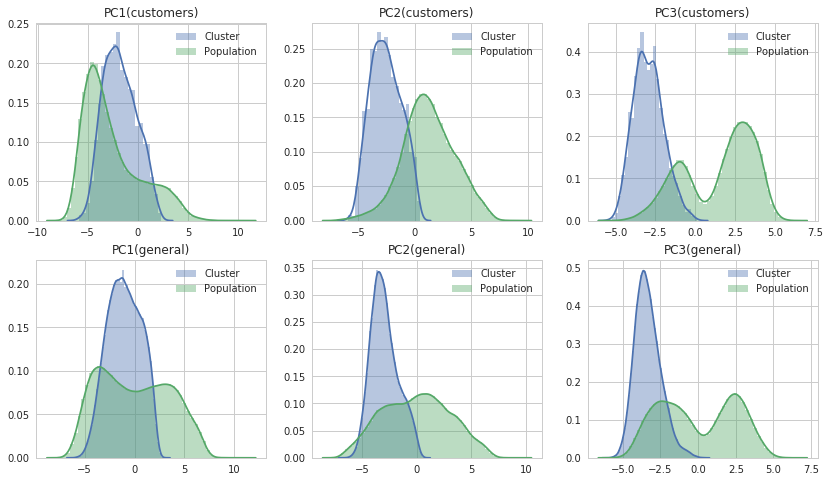

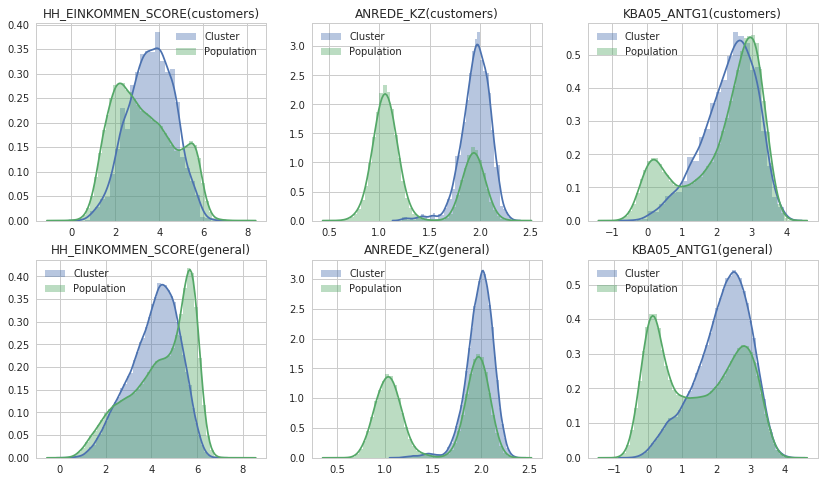

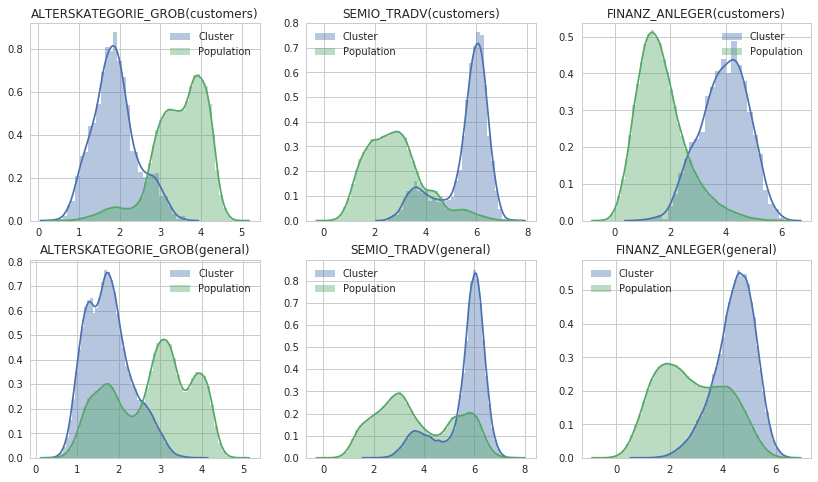

In [68]:
analyzecluster(11)

### Discussion 3.3: Compare Customer Data to Demographics Data

As discussed above, I have segmented the population into 12 different clusters. Due to the fact that in the general population datasets rows with high proportion of missing values have been qualitatively different from the rest, I have treated them as a special 13th cluster (in the above plot it is denoted by index 9999). The same assumption has been made also for the customers dataset. From the barplot comparing the cluster distribution for the two analyzed datasets it is clear that the customers dataset has a a much higher share of rows with missing data. I do not scrutiny the samples in the 13th cluster, but rather focus on other 12 clusters obtained through the clustering exercise. It is worth keeping in mind, however, that because of the different share of problematic rows the 12 clusters will, on average, have smaller relative ratios in the customers dataset than in the general population dataset.

From the barplot comparing cluster distributions it is clear that the customers dataset differs significantly from the general population dataset. Below I analyze the two most overrepresented clusters in the customers dataset, as well as the two most underrepresented ones. Before discussing the results, I briefly describe my comparison approach, as well as the above visualizations.

### Approach
For each over/under-represented cluster I have first compared the distribution of each of the first three principal components scores in a given cluster to their distribution on the entire population. I have performed such comparison separately on the general population dataset and on the customers dataset (distribution in the cluster is obviously similar, but the distribution of the entire population will differ). By comparing the two histograms in a given subplot I could analyze how principal component scores in a specific cluster differ from the score distribution on the entire population, and use interpretations of principal components (from Section 2.3) to infer what kind of people are represented by a specific cluster. For example, if a given principal score is mostly lower in the cluster than in the sample population, I would look at the features with prominent negative(positive) weights in the principal component, and try to understand what type of individuals are described with higher(lower) values in these features.

To further support the conclusions made through the analysis of principal component scores, I have performed an inverse transformation of the dataset back to the original space, and run the same comparison (cluster specific distribution vs population distribution) for 6 different features, which could help typify the clusters: HH_EINKOMMEN_SCORE (household income), ANREDE_KZ (gender), KBA05_ANTG1 (share of 1-2 family houses), ALTERSKATEGORIE_GROB (age), SEMIO_TRADV (affinity to traditional values) and FINANZ_ANLEGER (affinity to investing).

### Final Results
Cluster 5 is the most significantly overrepresented cluster. It represents 24.1% of the entries in the customers dataset, and only 6.2% in the general population dataset. It consists of male, middle-aged individuals who are very wealthy, live outside of dense urban areas, are potential homeowners, have high affinity to investing, above average affinity to traditional values. 

Cluster 6 is the second most overrepresented cluster (12.2% in the customers dataset versus 7.7% in the general population). It combines individuals that are in many aspects similar to the ones in Cluster 5, but in general slightly less wealthy, have lower affinity to investing, and less likely to live outside urban areas.

Cluster 10 is the most significantly underrepresented cluster, as it only represents 0.8% in the customers dataset, compared to 9.6% in the general population datasets. It consists of female, younger individuals who are part of low-income households, are residing in urban areas, have a very low affinity to saving or investing, have low affinity to traditional values and religion, and are not family-minded.

Cluster 11 is the second most underrepresented cluster (1% in the customers dataset versus 8.9% in the general population dataset). It combines individuals that are in many aspects similar to the ones in Cluster 10, but are not part of low-income households, and do not live in dense urban areas.